In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [3]:
%matplotlib inline

In [4]:
mpl.style.use('seaborn-whitegrid')

In [5]:
graph_params = {
    'figure.figsize': (15, 7),
    'axes.titlesize': 26,
    'axes.labelsize': 20,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'lines.linewidth': 2,
    'scatter.marker': '*',
    'lines.markersize': 10
}

In [6]:
plt.rcParams.update(graph_params)

## Урок 2
## Дискретные случайные величины. Закон распределения вероятностей. Биномиальный закон распределения. Распределение Пуассона

### Необходимые функции

In [7]:
def comb_count(n: int, k: int) -> int:
    result = math.factorial(n)/(math.factorial(k)*math.factorial(n - k))
    return result

In [8]:
def bin_prob(n: int, p: float, k: int) -> float:
    relevant_comb_count = comb_count(n, k)
    k_ones_prob = p**k
    remaining_zeros_prob = (1-p)**(n-k)
    result = relevant_comb_count*k_ones_prob*remaining_zeros_prob
    return result

In [9]:
def poisson_prob(lam: float, k: int) -> float:
    return (lam**k)*math.exp(-lam)/math.factorial(k)

In [10]:
def Mx(x: List[int] = list(), px: List[float] = list(), distr: pd.DataFrame = pd.DataFrame(columns=['X', 'prob'])) -> float:
    #print('\n'.join([_.__repr__() for _ in [x, px, distr]]))
    if x and px:
        assert len(x) == len(px), "Кол-во значений вероятностей не соответствует кол-ву значений случайной величины"
        result = 0
        for x, p in zip(x, px):
            result += x*p
        return result
    elif not distr.empty:
        assert 'X' in distr.columns and 'prob' in distr.columns, "Фрейм должен содержать столбцы x и prob со значениями случайной величины \
                                                                      и соответствующими вероятностями"
        result = sum(distr['X']*distr['prob'])
        return result
    else:
        raise ValueError("Должны быть заданы значения случайной величины и соответствующие значения вероятностей!")

In [11]:
def Dx(x: List[int] = list(), px: List[float] = list(), distr: pd.DataFrame = pd.DataFrame(columns=['X', 'prob'])) -> float:
    M = Mx(x, px, distr)
    # секция для случая непустого массива Х
    sqr_err = [(M - x)**2 for x in x]
    # секция для случая непустого фрейма распределения Х
    distr_err = distr.copy()
    distr_err['X'] = (M - distr_err['X'])**2
    # итоговая секция
    D = Mx(sqr_err, px, distr_err)
    return D        

### Задача 1

#### Условие

Контрольная работа состоит из пяти вопросов. На каждый вопрос приведено четыре варианта ответа, один из которых правильный. Случайная величина X задаёт число правильных ответов при простом угадывании. Составьте закон распределения случайной величины X. Найдите математическое ожидание и дисперсию данной случайной величины.

#### Решение

* При простом угадывании из четырех вариантов ответов, вероятность получить правильный будет равна $1/4$.
* Ответ на один вопрос - это одно испытание с бинарным результатом (правильный или неправильный ответ), 
* Контрольная - серия из 5 испытаний 

Значит закон распределения будет соответствовать биномиальному с $n = 5$ и $p = 0.25$

###### Зададим значения параметров

In [12]:
n = 5
p = 0.25

###### Значения, которые может принимать случайная величина

In [13]:
X = [_ for _ in range(6)]

###### Вероятности, соответствующие значениям случайной величины

In [14]:
Px = [bin_prob(n, p, x) for x in X]

###### Закон распределения случайной величины Х

In [15]:
distr_X = pd.DataFrame.from_dict({
    'X': X,
    'prob': Px
})

Text(0.5, 0, 'Кол-во правильных ответов')

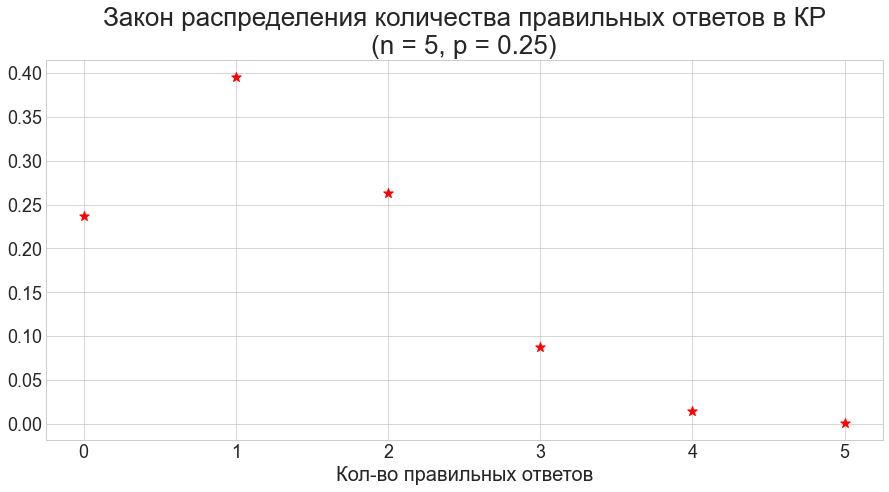

In [16]:
fig = plt.scatter(x=distr_X['X'], y=distr_X['prob'], color='r')
plt.title('Закон распределения количества правильных ответов в КР\n(n = 5, p = 0.25)')
plt.xlabel('Кол-во правильных ответов')

ПС: мне кажется, что для дискретных случайных величин правильно отображать закон распределения в виде scatterplot, а не lineplot, а то на графике будут какие-то значения вероятностей для значений случайной величины, не входящих в область определения.

###### Мат ожидание и дисперсия Х

In [17]:
Mx(distr=distr_X)

1.25

In [18]:
Dx(distr=distr_X)

0.9375

### Задача 2

#### Условие

Пользователь получает в среднем 10 писем со спамом на свой почтовый ящик за сутки. Найти число $N$, такое, что с вероятностью 0.95 пользователь получит не более $N$ писем со спамом за текущий день.

#### Решение

Допустим, что получение спама - цепь независимых событий, хотя это может быть и не так. Формулировка задачи намекает на использование распределения Пуассона. Так как условие на $N$ поставлено, как "не более", то будем суммировать вероятности для количества писем, начиная с 0 с шагом 1 до достижения нужного порога по вероятности.

In [19]:
lam = 10 # параметр распределения Пуассона
p_val = 0.95 # наше пороговое значение вероятности

In [20]:
p = 0 # переменная для хранения значения вероятности получить кол-во спама не более текущего значения
spam_mails_count = 0 # текущее значение кол-ва спама
while p < p_val:
    Psmc = poisson_prob(lam=lam, k=spam_mails_count) # вероятность получить кол-во спама в точности равное текущему значению
    p += Psmc
    spam_mails_count += 1

###### Полученное значение вероятности

In [21]:
round(p, 3)

0.951

###### Полученное максимальное количество спама в день для заданной вероятности 95%

In [22]:
spam_mails_count

16

### Задача 3

#### Условие

Производятся выстрелы по мишени. Вероятность попадания в мишень при одном выстреле равна 0.01. Сколько выстрелов нужно сделать чтобы быть уверенным с вероятностью 0.9, что хотя бы 6 раз будет совершено попадание?

#### Решение

* если говорим "не более", "хотя бы" и т.д. - значит речь пойдет о сумме вероятностей, 
* базовым случаем будет попадание k раз из n выстрелов - это биномиальное распределение,
* $P(X >= 6) = 1 - P(X < 6)$
* $X >= 6 <=> X > 5$ в данном случае, так как шаг кол-ва выстрелов равен 1

In [23]:
n = 6 # начальное количество выстрелов логично поставить равным 6, вдруг сразу попадем))
p = 0.01
p_val = 0.9 # наше пороговое значение вероятности
Pmt5 = 0 # переменная для хранения вероятности попасть больше 5 раз при текущем количестве выстрелов
while Pmt5 < p_val:
    P = 0 # переменная для хранения вероятности попасть меньше 6 раз при текущем количестве выстрелов
    for k in range(6):
        P += bin_prob(n=n, p=p, k=k)
    Pmt5 = 1 - P
    n += 1

###### Полученное значение вероятности

In [24]:
round(Pmt5, 4)

0.9004

###### Полученное необходимое количество выстрелов

In [25]:
n

927